In [1]:
# import (most of the) modules that we need
import time
import re
import os
from multiprocessing import Process
import numpy as np
import pylsl
from datetime import datetime
from nftools import guis
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types
from nftools.threshold import find_mode, contiguous_regions, detect_bursts, determine_optimal_threshold
import mne
import dynarray
import pickle
from scipy import io as spio
import matplotlib.pyplot as plt
from pynfb.protocols.ssd.topomap_selector_ica import ICADialog

In [2]:
# use the qt event loop, disable warnings (they flood the screen)
%matplotlib qt  
# %gui qt

import warnings; warnings.filterwarnings('ignore') 
mne.set_config('MNE_LOGGING_LEVEL', 'WARNING')

## 1.2 Define sub, ion and run numbers
- this will also load all the available data - if they've already been recorded!

In [3]:
# change these according to which sub-sess we have:

dataset='BrainTraining' # Rockhampton and Newcastle are other options for this

sub = 20
ses = 1
run = 1

In [4]:
# define where we put our stuff - prepare for BIDS Format Style
home_dir = os.path.expanduser('~')
save_dir = os.path.join(home_dir, 'nf/rawdata/{}/bids'.format(dataset))

this_save_dir = os.path.join(save_dir, 'sub-{:02d}'.format(sub), 'ses-{:02d}'.format(ses), 'eeg')

# we should also ... MAKE this savedir! If it exists, we don't do anything.
if not os.path.exists(this_save_dir):
    os.makedirs(this_save_dir)
    print("Directory " , this_save_dir ,  " Created ")
else:    
    print("Directory " , this_save_dir ,  " already exists")   
    
    
# expected files to be read/written:
fname_raw_localizer = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'efl', run))


# if files exist, load them
if os.path.exists(fname_raw_localizer):
    print('found raw eyes open: \t\t' + os.path.basename(fname_raw_localizer))
    raw_data = mne.io.read_raw_fif(fname_raw_localizer, preload=True)
   

Directory  /home/johan/nf/rawdata/BrainTraining/bids/sub-20/ses-01/eeg  already exists
found raw eyes open: 		sub-20_ses-01_task-efl_run-01.fif


In [5]:
# prints out which streams are currently available
stream_ids = [ pylsl.stream_inlet(s).info().source_id() for s in pylsl.resolve_streams() ]
print(stream_ids)

['openbci_aux_id15', 'openbci_eeg_id15']


- copy/paste the eeg lab name (left of the 2 outputs) into stream_id variable:
- thake the one that says **eeg**, not aux!

## 1.3 Connect to real-time stream

In [6]:
# 'subscribe' to a data stream; grab all essential(s), fs, names, etc
# stream_id = 'openbci_eeg_id134'

# eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*_eeg_.*', stream_id)]
eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*eeg.*', stream_id)]
if len(eeg_stream_id)>0:
    eeg_stream_id=eeg_stream_id[0]
print(eeg_stream_id)

openbci_eeg_id15


In [7]:
# try grabbing all the information from that stream:
data_stream=pylsl.resolve_byprop("source_id", eeg_stream_id, timeout=5.0)
if data_stream:
    data_inlet=pylsl.stream_inlet(data_stream[0], max_buflen=100)
    stream_info = data_inlet.info()
    stream_Fs = stream_info.nominal_srate()
    stream_xml = stream_info.desc()
    chans_xml = stream_xml.child("channels")
    chan_xml_list = []
    ch = chans_xml.child("channel")
    while ch.name() == "channel":
        chan_xml_list.append(ch)
        ch = ch.next_sibling("channel")
    channel_names = [ch_xml.child_value("label") for ch_xml in chan_xml_list]
    data_inlet_dt = data_inlet.time_correction(timeout=5.0)
    sampling_freq = data_stream[0].nominal_srate()
    print('name = %s' % data_stream[0].name())
    print('sampling_freq = %d' % sampling_freq)
    print('channel_count = %d' % data_stream[0].channel_count())
    print('channel_format = %d' % data_stream[0].channel_format())
else:
    raise Exception('No Data Stream Found - Is your EEG Cap running?')

name = openbci_eeg
sampling_freq = 125
channel_count = 16
channel_format = 1


# 2 Run the EEG-fMRI Localizer task on the Stimulation PC

## 2.1 Start Marker Server

In [8]:
# import netifaces
#default_interface=netifaces.gateways()['default'][netifaces.AF_INET][1]
#ip_address=netifaces.ifaddresses(default_interface)[netifaces.AF_INET][0]['addr']
ip_address='20.100.0.1'
port = 6500
#print('Tell Stimulus computer to send markers to our interface {} with ip={} and port={}'.format(default_interface, ip_address, port))

from multiprocessing import Process, Queue
import socket
import time

def my_marker_server(marker_queue, PORT):
    # simple markers server.
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(('', PORT))
    print("Listening on {}:{}".format('', PORT))
    reference_time = time.time()
    while True:
        data = sock.recv(1024)
        if data == b'stop_server':
            break
        if data == b'reset_timer':
            reference_time = time.time()
        my_timestamp  = time.time() - reference_time
        marker_queue.put((data.decode(), my_timestamp))

    print('finished')
    sock.close()
    
def send_stop_it(port):
    sock=socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(b'stop_server', ('localhost', port))
    sock.close()
    time.sleep(0.5)
                         
def reset_timer(port):
    sock=socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(b'reset_timer', ('localhost', port))
    sock.close()
    time.sleep(0.5)

if not 'marker_queue' in locals():
    marker_queue = Queue()
if 'my_udp_server' in locals():
    # we stop the marker server
    send_stop_it(port)
    try:
        # and we try to join it
        my_udp_server.join()
    except:
        del(my_udp_server)
        
my_udp_server = Process(target=my_marker_server, args=(marker_queue, port))
my_udp_server.start()

Listening on :6500


In [22]:
from callpyff import bcinetwork, bcixml
bcinet = bcinetwork.BciNetwork('20.100.0.2', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

__new__: I found an instance of BciNetwork!!
and it uses your requested port: 12346 == 12346
calling close_srvsocket on the previous instance.
closing...


## 2.2 Start the stimulation

In [23]:
print(bcinet.getAvailableFeedbacks())

['TestD2', 'MovingRhomb', 'EOEC', 'LibetClock', 'BrainWaveTraining_II', 'TobiQLAdapter', 'EyetrackerRawdata', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'StopVigilanceTask', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'VisualOddball', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'RestingState', 'NFBasicThermometer', 'RSVPSpeller', 'EEGfMRILocalizer', 'Oddball', 'Lesson01b', 'GoalKeeper', 'CenterSpellerVE', 'MultiVisualOddball', 'StroopFeedback', 'ERPMatrix', 'Lesson04', 'Lesson05', 'Lesson06', 'Lesson01', 'Lesson02', 'Lesson03', 'VisualOddballVE']


In [24]:
bcinet.send_init('EEGfMRILocalizer')

In [25]:
# tell the stimulus about the monitor; trial-and-error to fix it:
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXWIDTH': 1366},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXHEIGHT': 768},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_FULLSCR': True},None, bcixml.INTERACTION_SIGNAL))
# bcinet.send_signal(bcixml.BciSignal({'MONITOR_USEDEGS': False},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_DEGS_HEIGHTBASE': 18},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_DEGS_WIDTHBASE': 25},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'VIS_checkerSize': 0.75},None, bcixml.INTERACTION_SIGNAL))

# do we do the artifact measurement Program?
bcinet.send_signal(bcixml.BciSignal({'CAL_DO_ARTIFACT_PROGRAM': False},None, bcixml.INTERACTION_SIGNAL))

# do we do pre-main experiment eyes open / eyes closed?
bcinet.send_signal(bcixml.BciSignal({'CAL_DO_PRE_EOEC': False},None, bcixml.INTERACTION_SIGNAL))
# do we do post-main experiment eyes open / eyes closed?
bcinet.send_signal(bcixml.BciSignal({'CAL_DO_POST_EOEC': False},None, bcixml.INTERACTION_SIGNAL))

# where do we live, ip-address-wise, so we can receive stimulus markers?
bcinet.send_signal(bcixml.BciSignal({'EVENT_destip': ip_address},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'EVENT_destport': port},None, bcixml.INTERACTION_SIGNAL))

In [26]:
bcinet.play()

# 3 Data acquisition

## 3.1 the data acquisition loop

In [27]:
# we put the incoming data in here:
np_data = dynarray.DynamicArray((None, len(channel_names))); times_of_samples = []

# collect markers from the Stimulation:
stim_Annotations = mne.Annotations(0, 0, 'start localizer')

# init/open the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as button 'stop' not pressed:
reset_timer(port)
w.RUNLOOP=True
while w.RUNLOOP:
    
    # grab markers
    while not marker_queue.empty():
        marker_code, my_timestamp = marker_queue.get()
        stim_Annotations.append(my_timestamp, 0, marker_code)

    # grab data
    if not data_inlet.samples_available():
        w.update(None)
    else:
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL
        
        np_data.extend(chunk_data) # add data our list
        times_of_samples.append(chunk_times) # grab the timing information
        w.update(chunk_data) # update the signal window       

    # avoid making too many cpu cycles
    time.sleep(0.001)
        

## 3.2 make an MNE python rawdata from it

In [28]:
# and we make the MNE data file from it
raw_data = mne.io.RawArray(np.transpose(np_data)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                        )
                   )

# we make an lsl packet membership so we can check transmission statistics
lsl_packet = np.array([i 
          for i, c in enumerate([len (x) for x in times_of_samples]) 
          for n in range(c)]
        )

# make a lsl timestamp signal (essential later on)
lsl_time = np.concatenate(times_of_samples) - times_of_samples[0][0]

# We add this infmrmation to the raw.
info_lslinfo = mne.create_info(('lsl_time','lsl_packet'), sampling_freq, ('misc','misc'))
raw_lslinfo = mne.io.RawArray((lsl_time, lsl_packet), info_lslinfo)
raw_data.add_channels([raw_lslinfo])

<RawArray  |  None, n_channels x n_times : 18 x 79796 (638.4 sec), ~11.0 MB, data loaded>

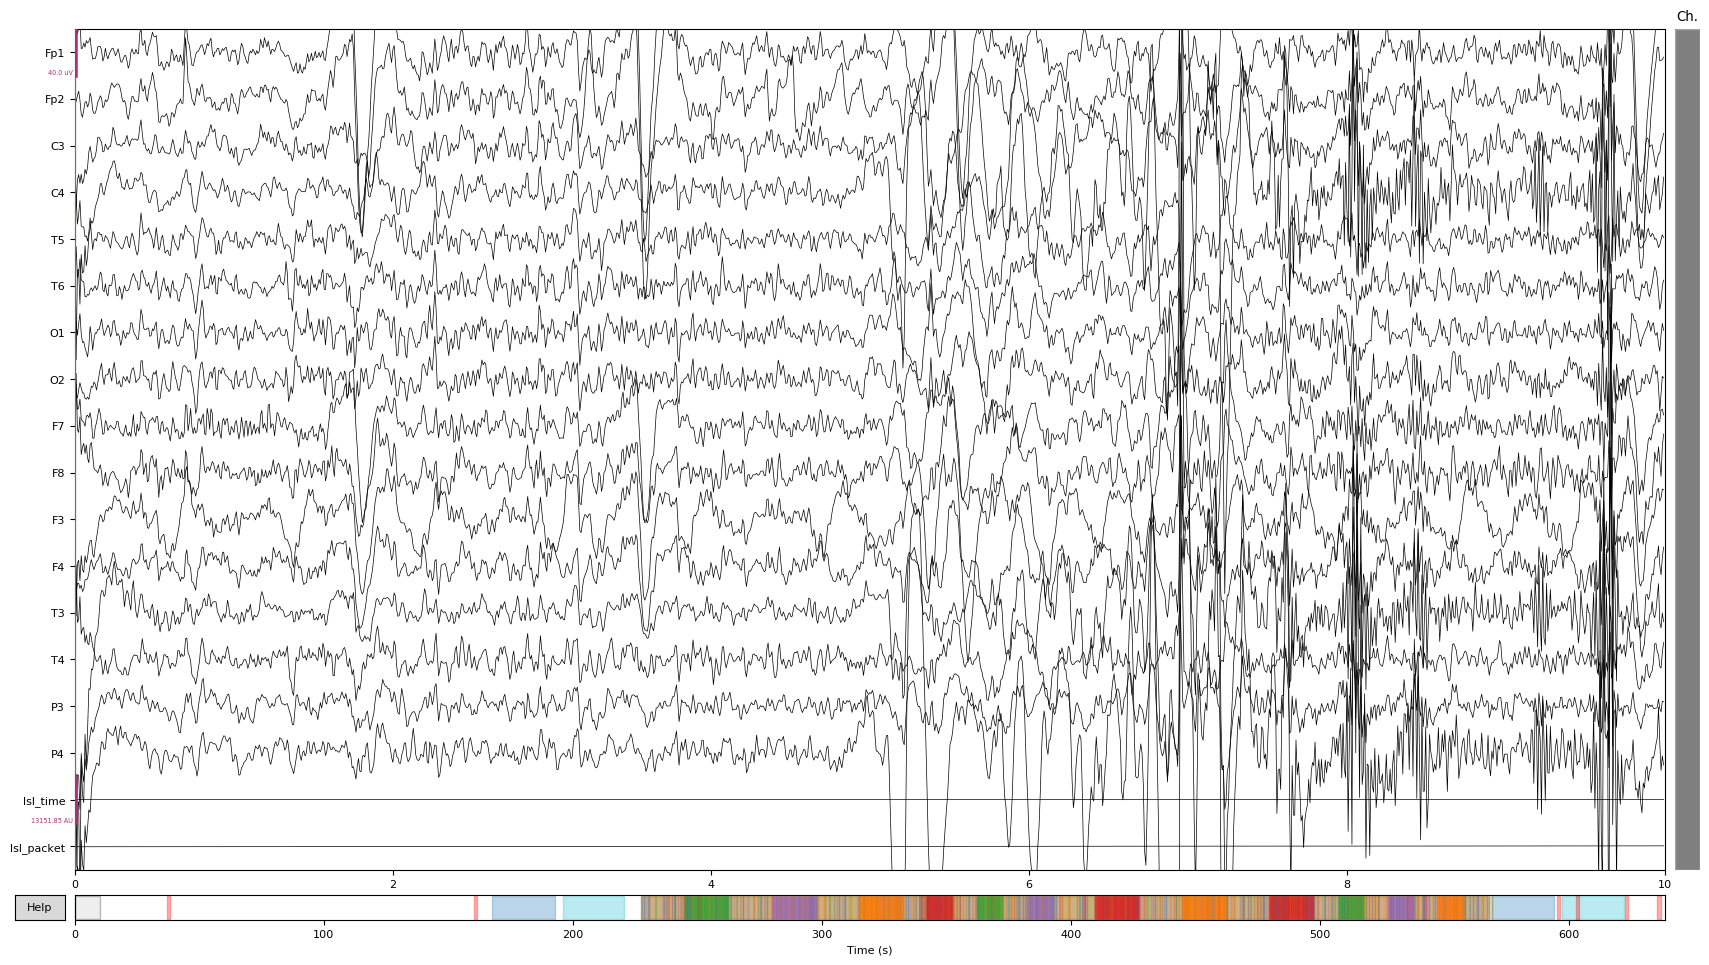

In [5]:
raw_data.copy().filter(3, 40).notch_filter((25, 50)).plot()

## 3.3 Deal with the markers and time corrections

In [54]:
all_markers = {        
    # Stop / Inhibit Response Codes
    'BeginGoL':1,
    'BeginGoR':2,
    'BeginStopL':3,
    'BeginStopR':4,
    'RespL':5,
    'RespR':6,

    # somce some responses are not logged (because of too soon or too late or multiple presses)
    # log the keyboard separately.
    'KeyL': 7,        
    'KeyR': 8,
    'WrongKey': 9,

    'CorrectGoL':11,
    'CorrectGoR':12,
    'CorrectStopL':13,
    'CorrectStopR':14,
    'ErrorCommission':15,
    
    # don't expect too many of these:
    'ErrorOmission':21,
    'PressedTooSoon':22,
    'PressedTooLate':23,
    'TooManyResponses':24,
    'WrongSideErrorCommission':25,
    'WrongSideGo':26,

    'gonogo_BEGIN': 30,
    'gonogo_END': 31,

    # visual SSVEP checkerboard codes (8 and 13 Hz)
    #
    # when the contrast inverts, for SSVEP deconvolution
    'vis_l8':81,
    'vis_r8':82,
    'vis_l13':131,
    'vis_r13':132,

    # begin and end markers (for EEG frequency analysis), 8Hz and 13Hz
    'vis_bl8':83,
    'vis_br8':84,
    'vis_el8':85,
    'vis_er8':86,

    'vis_bl13':133,
    'vis_br13':134,
    'vis_el13':135,
    'vis_er13':136,

    'vis_BEGIN': 80,
    'vis_END': 140,

    # audio SSVEP codes (40 Hz and 55 Hz)
    #
    # when audio sample starts -- one audio sample contains 32 
    'aud_l40':41,
    'aud_r40':42,
    'aud_l55':51,
    'aud_r55':52,

    'aud_bl40':43,
    'aud_br40':44,
    'aud_el40':45,
    'aud_er40':46,

    'aud_bl55':53,
    'aud_br55':54,
    'aud_el55':55,
    'aud_er55':56,
    
    'aud_BEGIN': 40,
    'aud_END': 60,
    
    # eyes open / eyes closed markers:
    'eo_BEGIN': 201,
    'eo_END': 202,
    'ec_BEGIN': 203,
    'ec_END': 204,
    
    # artifact measurement program markers:
    'h4l':221,
    'h4r':222,
    'h8l':223,
    'h8r':224,
    'v4u':225,
    'v4d':226,
    'v8u':227,
    'v8d':228,
    'c':229,
    'hvest':231,
    'hvestp':232,
    'vvest':233,
    'vvestp':234,
    'eyeblinks':241,
    'neckl':242,
    'neckr':243,
    'jaw':244,
    'eyebrows':245,
    'swallow':246,
    'cheeks':247,
        
    }



In [55]:
# bookkeeping on the annotations! - make things nice, clear, easy to understand...
new_annots = mne.Annotations(0, 0, ''); new_annots.delete(0)

# convert marker dict to inverted marker dict: allow us to put the codes in the EEG trace:
inverted_marker_dict={v:k for k, v in all_markers.items()}

for a in stim_Annotations:
    
    current_onset = a['onset']
    try:
        current_description = inverted_marker_dict[int(a['description'])]

        if 'BEGIN' in current_description:
            this_part_onset = current_onset
            this_part_description = current_description.strip('_BEGIN')
        elif 'END' in current_description:
            this_part_description = current_description.strip('_END')
            new_annots.append(this_part_onset, current_onset - this_part_onset, this_part_description)    
        else:
            new_annots.append(current_onset, 0, current_description)
            
    except:
        pass
# I draft this code by searching the internet for whatever I need.

NameError: name 'stim_Annotations' is not defined

In [53]:
# these are all annotations so far - we're going to correct their onsets:            
all_annotations = new_annots

# put the markers at the right spot by median filter of delay w.r.t. naive time:
uncorrected_time = raw_data.times
from scipy.ndimage import median_filter
delay_model=median_filter(lsl_time - uncorrected_time, round(1.0*sampling_freq))
corrected_time = uncorrected_time + delay_model

# this seems a bad way to loop over the annotations - but it is
# the only way to actually change the onset timings (normal looping - doesn't work!)
for i in range(len(all_annotations)):
    uncorrected_timestamp = all_annotations.onset[i]
    corrected_index = np.argmin(abs(corrected_time - uncorrected_timestamp))
    corrected_timestamp = corrected_index / sampling_freq
    all_annotations.onset[i] = corrected_timestamp

In [54]:
# determine segments that are bad, and annotate them too:
wsize = round(0.5*sampling_freq)
# to facilitate sliding window selection with indices
sliding_inds = iter([range(s, s+wsize) for s in range(len(delay_model)-wsize)])
# determine slope and intercept in sliding window
# slopes, intercepts = np.array([np.polyfit(inds, delay_model[inds], 1) for inds in sliding_inds]).T
d=delay_model
slopes=np.array([sum([(d[s+i] - d[s])/i for i in range(1, wsize)])/(wsize-1) for s in range(len(d)-wsize)])
# the threshold (works well)
thr = 1/sampling_freq - 1/(sampling_freq + 0.5)
# thr = (1/sampling_freq - 1/(sampling_freq+0.5))*4
# true/false array of bad points -- but broaden it a little bit more (1 second)

bad_points=np.convolve(abs(np.diff(slopes)) > thr, np.ones(round(sampling_freq), dtype='bool'), mode='same')

In [55]:
# make our dictionary -> later will be converted towards annotation(s)
bad_segments = []
# a list of index items
cur_prev_inds = iter([(s, s+1) for s in range(len(bad_points)-1)])
for i, (cur, nxt) in enumerate(cur_prev_inds):
    
    if bad_points[nxt] and not bad_points[cur] or bad_points[cur] and i == 0:
        # we need to add half length of window size for getting the real start
        bad_segments.append({'start':i + round(wsize/2), 'duration':0})
    if bad_points[nxt] and bad_points[cur]:
        bad_segments[-1]['duration'] += 1

In [56]:
# insert these bad segments as annotations
# no tdelay correction necessary -- we know the samples
bad_segment_annots = mne.Annotations(0, 0, ''); bad_segment_annots.delete(0)
for segment in bad_segments:
    bad_segment_annots.append(segment['start']/sampling_freq, segment['duration']/sampling_freq, 'BAD_Transmission')

all_annotations += bad_segment_annots

In [57]:
# this takes few seconds
fig=plt.figure(figsize=(15, 5))
plt.plot(lsl_time-uncorrected_time)
plt.plot(delay_model)
ylims = plt.ylim()
plt.xlim(0, len(lsl_time))
plt.xlabel('sample'); plt.ylabel('delay (s)')

for segment in bad_segments:
    plt.vlines(segment['start']+segment['duration']/2, *ylims)
fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}_delaycorrection.jpg'.format(sub, ses, 'raw-efl', run)
plt.title(fname)
fig.tight_layout()

plt.savefig(os.path.join(this_save_dir, fname))
# plt.close(fig)

## 3.4 Saving the data structures

In [58]:
# saving the raw data - as of yet, NO annotations!
this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'efl', run)
fname_raw_data_run = os.path.join(this_save_dir, this_raw_fname)
raw_data.set_annotations(all_annotations)
raw_data.save(fname_raw_data_run, overwrite=True)
print('saved: ' + fname_raw_data_run)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-20/ses-01/eeg/sub-20_ses-01_task-raw-efl_run-01.fif


## 3.5 Inspect the eo data  (run1)
- scroll through the data see if the EEG signal is what you expect
- mark bad channels (that cannot be rescued)
- mark bad segments

In [59]:
# we use a simple display filter
raw_data_copy = raw_data.copy()
raw_data_copy.filter(1, 40).notch_filter((25, 50)).plot(title='localizer - raw data');

- save this raw data to disk (filename taken care of)

# 4 Do some Analysis

## 4.1 visual checkerboard




In [95]:
preprocessed_raw = raw_data.copy().filter(3, 45).notch_filter((25,50))

# make events from annotations; make them all event '1'
events, event_id=mne.events_from_annotations(raw_data, event_id={'vis_l13':1, 'vis_r13':1});
evoked_lr = mne.Epochs(preprocessed_raw, events, event_id, tmin=-0.05, tmax=0.35)

events, event_id=mne.events_from_annotations(raw_data, event_id={'aud_l40':1});
evoked_l = mne.Epochs(preprocessed_raw, events, event_id, tmin=-0.05, tmax=0.35)

events, event_id=mne.events_from_annotations(raw_data, event_id={'aud_r40':1});
evoked_r = mne.Epochs(preprocessed_raw, events, event_id, tmin=-0.05, tmax=0.35)


In [16]:
from mne.viz import plot_compare_evokeds

In [17]:
plot_compare_evokeds(evoked_l)

TypeError: "evokeds" must be a dict, list, or instance of mne.Evoked; got Epochs

In [96]:
evoked_lr.plot_image(picks='Fp1');

In [88]:
reject = dict(eeg=250e-6)

In [89]:
evoked_lr.drop_bad(reject)

<Epochs  |   464 events (all good), -0.048 - 0.352 sec, baseline [None, 0], ~53 kB, data not loaded,
 'vis_l8': 464
 'vis_r8': 464>

In [99]:
evoked_lr.plot_image(picks='O1')

[<Figure size 640x480 with 4 Axes>]

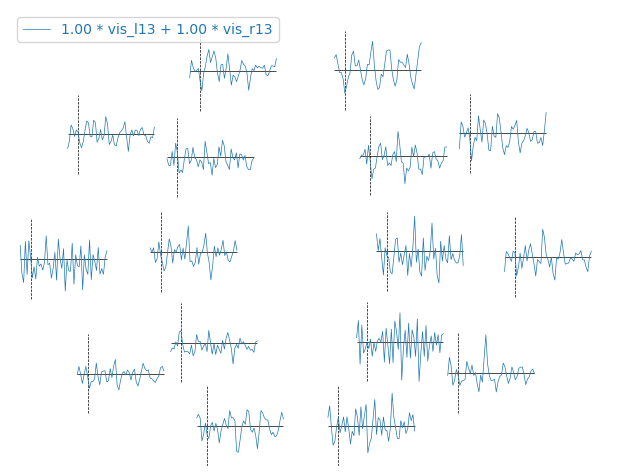

In [98]:
evoked_lr.average().plot_topo()

In [91]:
evoked_lr.plot_image(picks='O1')

[<Figure size 640x480 with 4 Axes>]

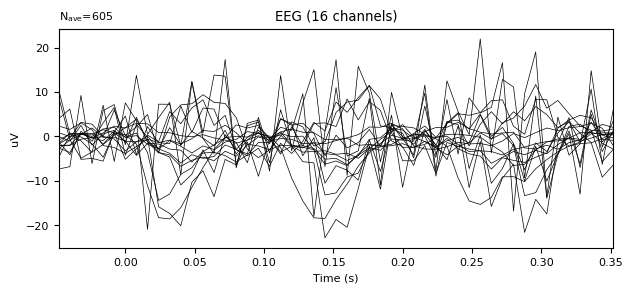

In [23]:
av_epoch.plot()

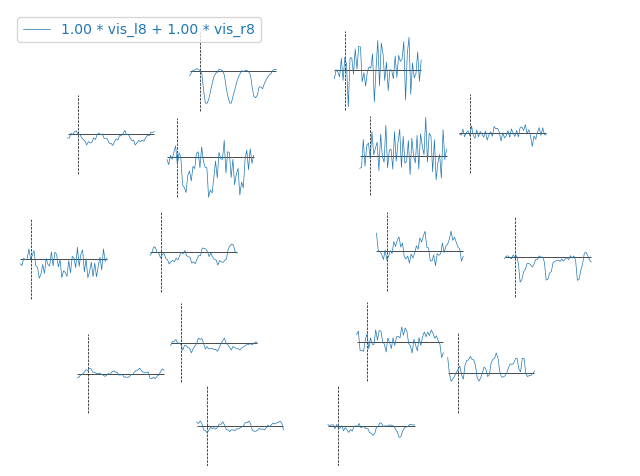

In [97]:
av_epoch.plot_topo()

In [26]:
events, event_id=mne.events_from_annotations(raw_data, event_id={'vis_l13':1, 'vis_r13':1});
evoked_lr = mne.Epochs(preprocessed_raw, events, event_id, tmin=-0.05, tmax=0.35)

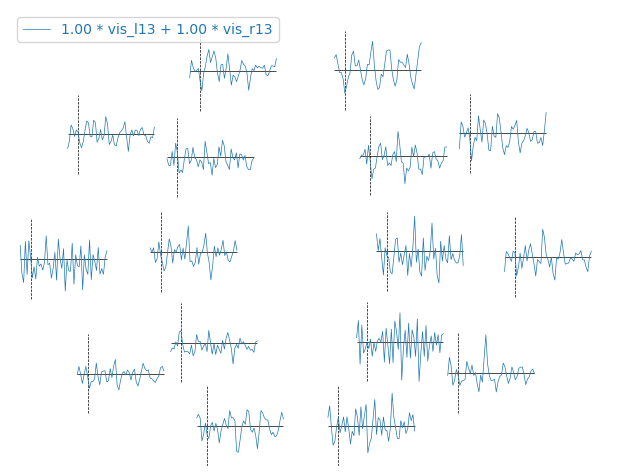

In [28]:
evoked_lr.average().plot_topo()

In [38]:
evoked_lr.plot_image()

[<Figure size 640x480 with 3 Axes>]

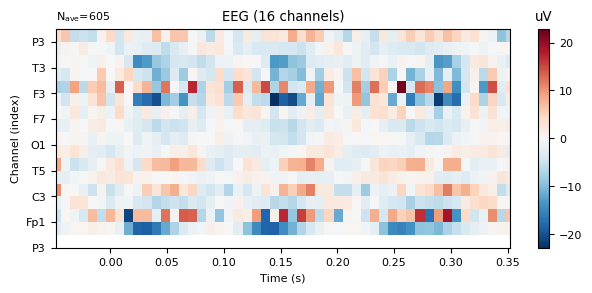

In [30]:
av_epoch.plot()

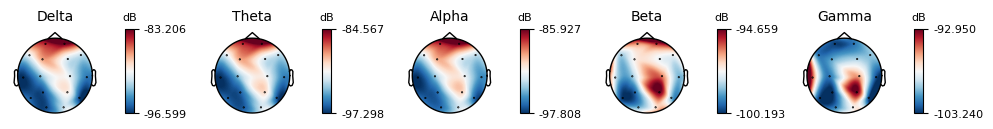

In [91]:
ev_epoch

In [34]:
evoked_lr.plot_image()

[<Figure size 640x480 with 3 Axes>]

In [8]:
v=raw_data.get_data(picks='lsl_time')[0]

In [9]:
plt.figure(); plt.plot(raw_data.times - v)

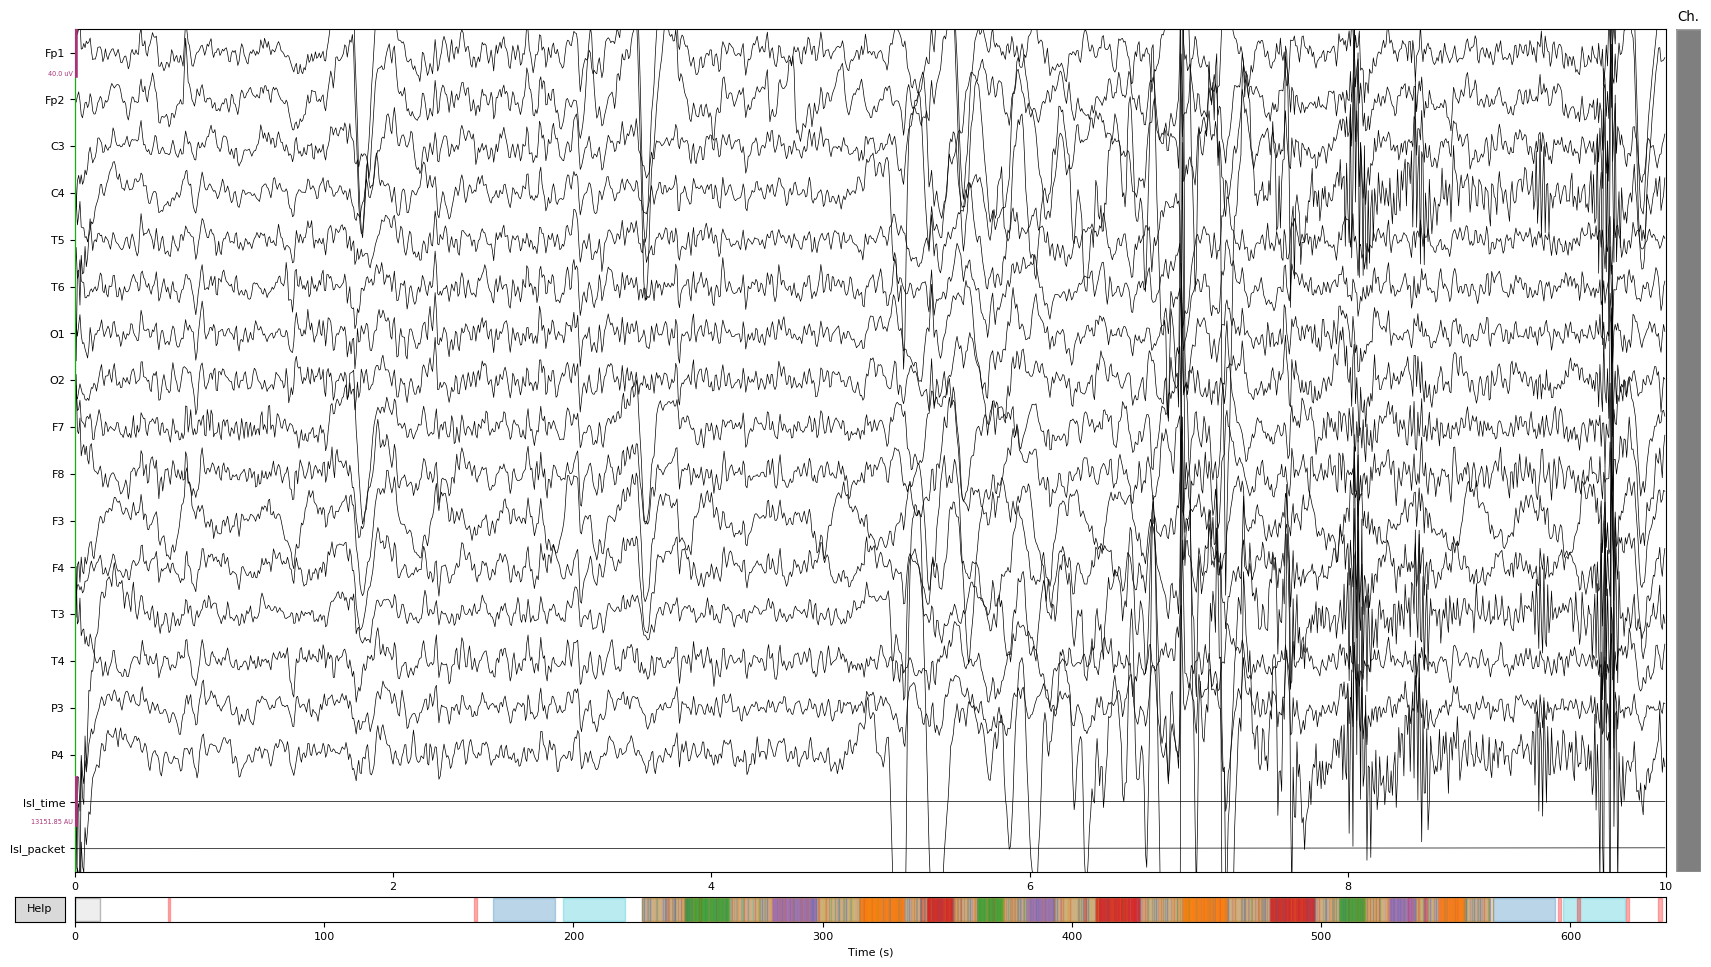

In [47]:
raw_data.copy().filter(3,40).notch_filter((25,50)).plot()

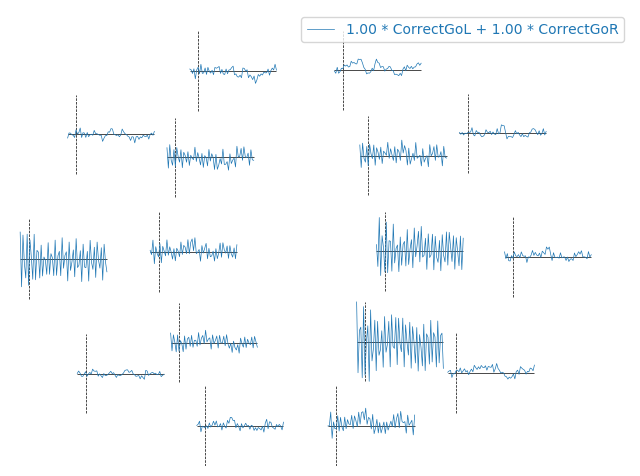

In [52]:
events, event_id=mne.events_from_annotations(raw_data, event_id={'CorrectGoL':1, 'CorrectGoR':1});
evoked_lr = mne.Epochs(preprocessed_raw, events, event_id, tmin=-0.05, tmax=0.45)
    
evoked_lr.average().plot_topo()

## Key rereferencing syntax


## Key data rejection syntax
- how to handle bad epoch rejections

In [ ]:
events = mne.find_events(raw, stim_channel='STI 014')
event_id = {"auditory/left": 1}
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
baseline = (None, 0)  # means from the first instant to t = 0
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                           stim=False, exclude='bads')
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks_meg, baseline=baseline, reject=reject,
                    reject_by_annotation=True)